In [1]:
# Vanilla policy gradient in keras with Reward-To-Go
# https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html

In [2]:
%pylab inline
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import gym
from tqdm import trange
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
env = gym.make("CartPole-v1")
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [4]:
x = in1 = Input(env.observation_space.shape)
x = Dense(32)(x)
x = Activation('tanh')(x)
x = Dense(env.action_space.n)(x)
x = Lambda(lambda x: tf.nn.log_softmax(x, axis=-1))(x)
m = Model(in1, x)
def loss(y_true, y_pred):
  # y_pred is the log probs of the actions
  # y_true is the action mask weighted by sum of rewards
  return -tf.reduce_sum(y_true*y_pred, axis=-1)
m.compile(Adam(1e-2), loss)
m.summary()
lll = []

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [5]:
# this is like 5x faster than calling m.predict and picking in numpy
pf = K.function(m.layers[0].input, tf.random.categorical(m.layers[-1].output, 1)[0])

tt = trange(40)
for epoch in tt:
  X,Y = [], []
  ll = []
  while len(X) < 8192:
    obs = env.reset()
    acts, rews = [], []
    while True:
      # pick action
      #act_dist = np.exp(m.predict_on_batch(obs[None])[0])
      #act = np.random.choice(range(env.action_space.n), p=act_dist)
      
      # pick action (fast!)
      act = pf(obs[None])[0]
      
      # save this state action pair
      X.append(np.copy(obs))
      acts.append(act)
      
      # take the action
      obs, rew, done, _ = env.step(act)
      rews.append(rew)
      
      if done:
        for i, act in enumerate(acts):
          act_mask = np.zeros((env.action_space.n))
          act_mask[act] = np.sum(rews[i:])
          Y.append(act_mask)
        ll.append(np.sum(rews))
        break
        
  loss = m.train_on_batch(np.array(X), np.array(Y))
  lll.append((np.mean(ll), loss))
  tt.set_description("ep_len:%7.2f    loss:%7.2f" % lll[-1])
  tt.refresh()

ep_len: 500.00    loss: 133.47: 100%|██████████| 40/40 [00:54<00:00,  1.39s/it]


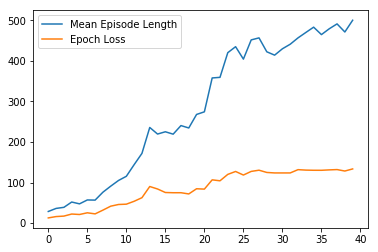

In [6]:
plot([x[0] for x in lll], label="Mean Episode Length")
plot([x[1] for x in lll], label="Epoch Loss")
plt.legend()